# Import libraries

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import findspark
findspark.init()
findspark.find() 

import pyspark.pandas as ps
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
DATASET_PATH = 'datasets/historical-hourly-weather-dataset/'
AGGREGATED_DATASET_PATH = 'datasets/historical-hourly-weather-dataset/aggregated_sampled_weather_measurements'

# Data pre-processing

### Data expansion & cleaning --> `Hung Nguyen`

### Data integration & label aggregation --> `Doan Hoang`

### Data statistics

Load data

In [3]:
# Get all the csv files in the aggregated dataset folder
csv_files = [file for file in os.listdir(AGGREGATED_DATASET_PATH) if file.endswith('.csv')]

# Read each CSV file into a Koalas DataFrame and store them in a list
dfs = [ps.read_csv(os.path.join(AGGREGATED_DATASET_PATH, file)) for file in csv_files]

# Combine the DataFrames using the concat function
data = ps.concat(dfs, ignore_index = True)

your 131072x1 screen size is bogus. expect trouble
23/11/12 23:07:45 WARN Utils: Your hostname, DASH resolves to a loopback address: 127.0.1.1; using 172.28.34.48 instead (on interface eth0)
23/11/12 23:07:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/12 23:07:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [4]:
features = [
    'humidity',
    'pressure',
    'temperature',
    'wind_direction',
    'wind_speed',
    'latitude',
    'longitude',
]

In [5]:
data.head()

/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,country,latitude,longitude
0,2014-07-17 22:00:00,41.0,1018.0,298.89,170.0,1.0,cloudy,Saint Louis,United States,38.62727,-90.197891
1,2014-07-17 23:00:00,44.0,1018.0,298.27,110.0,2.0,cloudy,Saint Louis,United States,38.62727,-90.197891
2,2014-07-22 02:00:00,65.0,1018.0,299.61,160.0,2.0,sunny,Saint Louis,United States,38.62727,-90.197891
3,2014-07-23 12:00:00,78.0,1016.0,298.73,240.0,2.0,foggy,Saint Louis,United States,38.62727,-90.197891
4,2014-07-25 19:00:00,68.0,1019.0,294.55,20.0,4.0,thunderstorm,Saint Louis,United States,38.62727,-90.197891


Descriptive statistics

In [6]:
data[features].describe().transpose()

23/11/12 23:08:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,count,mean,std,min,25%,50%,75%,max
humidity,51429.0,73.356880,20.633996,5.000000,62.000000,78.000000,89.000000,100.000000
pressure,51429.0,1017.105602,13.325850,803.000000,1012.000000,1017.000000,1023.000000,1100.000000
temperature,51429.0,286.629867,12.068791,243.620000,277.290000,288.470000,296.220000,317.350000
wind_direction,51429.0,183.879329,103.664813,0.000000,100.000000,190.000000,270.000000,360.000000
wind_speed,51429.0,3.175796,2.291689,0.000000,1.000000,3.000000,4.000000,35.000000
latitude,51429.0,37.886836,5.830631,25.774269,32.815559,39.099731,42.331429,49.249660
longitude,51429.0,-82.266883,38.715901,-123.119339,-104.984703,-86.784439,-79.416298,35.216331


Boxplot

/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/home/khanhdq109/anaconda3/envs/weather/lib/python3.9/site-packages/pyspark/pandas/utils.py:1016: PandasAPI

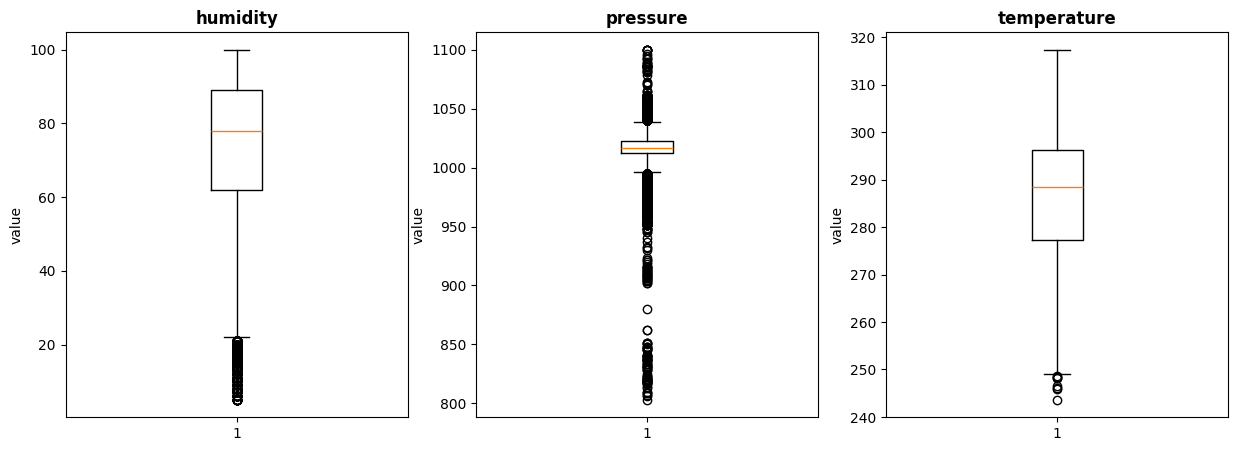

In [7]:
features = ['humidity', 'pressure', 'temperature']

# Plot the data
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

axs[0].boxplot(data[features[0]])
axs[0].set_ylabel('value')
axs[0].set_title(features[0], fontweight = "bold")

axs[1].boxplot(data[features[1]])
axs[1].set_ylabel('value')
axs[1].set_title(features[1], fontweight = "bold")

axs[2].boxplot(data[features[2]])
axs[2].set_ylabel('value')
axs[2].set_title(features[2], fontweight = "bold")

plt.show()

Distribution

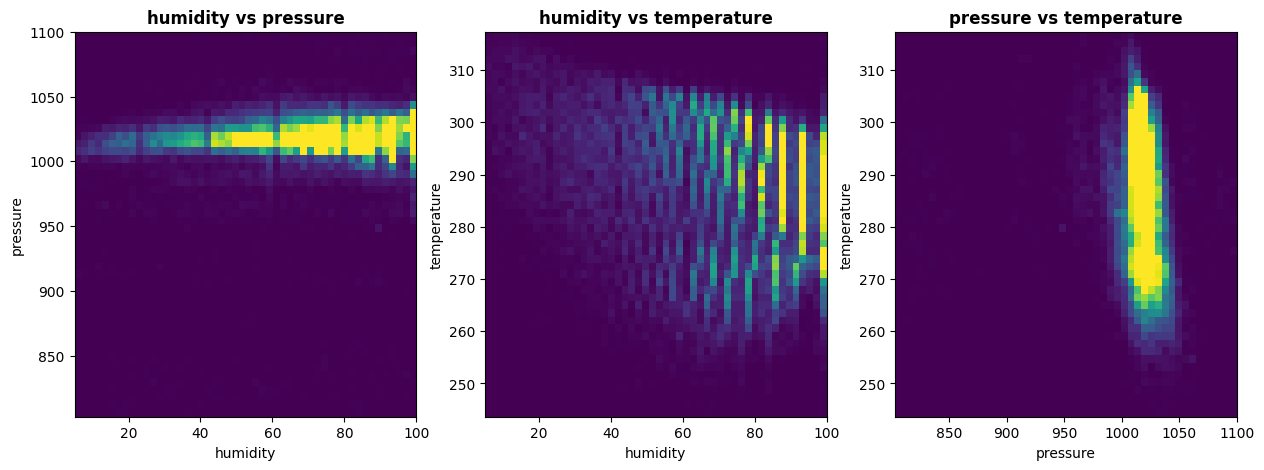

In [29]:
features = ['humidity', 'pressure', 'temperature']
f1_list = data[features[0]].tolist()
f2_list = data[features[1]].tolist()
f3_list = data[features[2]].tolist()

# Plot the data
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

axs[0].hist2d(f1_list, f2_list, bins = (50, 50), vmax = 200)
axs[0].set_xlabel(features[0])
axs[0].set_ylabel(features[1])
axs[0].set_title(features[0] + ' vs ' + features[1], fontweight = "bold")

axs[1].hist2d(f1_list, f3_list, bins = (50, 50), vmax = 200)
axs[1].set_xlabel(features[0])
axs[1].set_ylabel(features[2])
axs[1].set_title(features[0] + ' vs ' + features[2], fontweight = "bold")

axs[2].hist2d(f2_list, f3_list, bins = (50, 50), vmax = 200)
axs[2].set_xlabel(features[1])
axs[2].set_ylabel(features[2])
axs[2].set_title(features[1] + ' vs ' + features[2], fontweight = "bold")

plt.show()

# Machine Learning pipeline

### Load data

In [ ]:
# Get all the csv files in the aggregated dataset folder
csv_files = [file for file in os.listdir(AGGREGATED_DATASET_PATH) if file.endswith('.csv')]

# Read each CSV file into a Koalas DataFrame and store them in a list
dfs = [ps.read_csv(os.path.join(AGGREGATED_DATASET_PATH, file)) for file in csv_files]

# Combine the DataFrames using the concat function
data = ps.concat(dfs, ignore_index = True)

### Pre-processing

Select relevant features and label column

In [ ]:
# Select relevant features
numerical_cols = [
    'humidity',
    'pressure',
    'temperature',
    'wind_direction',
    'wind_speed',
    'latitude',
    'longitude'
]
nominal_cols = []
# Select the label column
label_col = 'weather_condition'
prediction_col = 'predicted_weather_condition'
# Select the features and the label
df_selected = data[numerical_cols + nominal_cols + [label_col]]

In [ ]:
df_selected.head()

In [ ]:
# Convert the Koalas DataFrame to a Spark DataFrame
df_selected = df_selected.to_spark()

Train-Test split

In [ ]:
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed = 42)

Encode

In [ ]:
def encode(
    df,
    numerical_cols = [],
    nominal_cols = [],
    label_col = '',
    with_std = True,
    with_mean = True,
):
    # Convert categorical label to numerical label
    label_indexer = StringIndexer(
        inputCol = label_col,
        outputCol = 'label',
        handleInvalid = 'keep'
    )
    
    # Assemble features into a vector
    feature_cols = numerical_cols + nominal_cols
    vector_assembler = VectorAssembler(
        inputCols = feature_cols,
        outputCol = 'raw_features'
    )
    
    # Scale the features
    scaler = StandardScaler(
        inputCol = 'raw_features',
        outputCol = 'scaled_features',
        withStd = with_std,
        withMean = with_mean
    )
    
    stages = [label_indexer, vector_assembler, scaler]
    pipeline = Pipeline(stages = stages)
    
    transformer = pipeline.fit(df)
    
    return transformer

In [ ]:
data_encoder = encode(
    df = df_selected,
    numerical_cols = numerical_cols,
    nominal_cols = nominal_cols,
    label_col = label_col
)

# Weather Forecasting models

In [ ]:
"""
    Support functions for training and evaluating the model
"""

# Evaluate the model
def evaluate(predictions):
    accuracy = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'accuracy'
    )
    precision = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'weightedPrecision'
    )
    recall = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'weightedRecall'
    )
    f1 = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'f1'
    )
    
    print('Accuracy:', accuracy.evaluate(predictions))
    print('Precision:', precision.evaluate(predictions))
    print('Recall:', recall.evaluate(predictions))
    print('F1:', f1.evaluate(predictions))
    
# Confusion matrix
def plot_confusion_matrix(predictions_df, normalize: bool = False, title: str = None): 
    labels = predictions_df.select(label_col).to_koalas().to_numpy()
    pedictions = predictions_df.select(prediction_col).to_koalas().to_numpy()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, pedictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, pedictions)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt), ha = 'center', va = 'center',
                color = 'white' if cm[i, j] > thresh else 'black'
            )

    fig.tight_layout()
    plt.show()
    
# Index to string
idx_to_str = IndexToString(
    inputCol = 'prediction',
    outputCol = prediction_col,
    labels = data_encoder.stages[0].labels
)

### Random Forest

Define the classifier

In [ ]:
classifier = RandomForestClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    numTrees = 15
)

Define the pipeline with the encoding and classifier stages

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data

In [ ]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data

In [ ]:
predictions = model.transform(test_data)

In [ ]:
evaluate(predictions)

In [ ]:
predictions = idx_to_str.transform(predictions)

Confusion matrix

In [ ]:
plot_confusion_matrix(predictions, normalize = True)

### Logistic Regression

Define the classifier

In [ ]:
classifier = LogisticRegression(
    featuresCol = 'scaled_features',
    labelCol = 'label',
)

Define the pipeline with the encoding and classifier stages

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data

In [ ]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data

In [ ]:
predictions = model.transform(test_data)

In [ ]:
evaluate(predictions)

In [ ]:
predictions = idx_to_str.transform(predictions)

Confusion matrix

In [ ]:
plot_confusion_matrix(predictions, normalize = True)

### Decision Tree

Define the classifier

In [ ]:
classifier = DecisionTreeClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
)

Define the pipeline with the encoding and classifier stages

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data

In [ ]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data

In [ ]:
predictions = model.transform(test_data)

In [ ]:
evaluate(predictions)

In [ ]:
predictions = idx_to_str.transform(predictions)

Confusion matrix

In [ ]:
plot_confusion_matrix(predictions, normalize = True)

### Multilayer Perceptron

Define the layers of the neural network

In [ ]:
layers = [len(numerical_cols) + len(nominal_cols), 32, 64, 128, 6]

Define the classifier

In [ ]:
classifier = MultilayerPerceptronClassifier(
    layers = layers,
    blockSize = 128,
    seed = 42,
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxIter = 500
)

Define the pipeline with the encoding and classifier stages

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data

In [ ]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data

In [ ]:
predictions = model.transform(test_data)

In [ ]:
evaluate(predictions)

In [ ]:
predictions = idx_to_str.transform(predictions)

Confusion matrix

In [ ]:
plot_confusion_matrix(predictions, normalize = True)

# Comparison with [OpenWeather](https://openweathermap.org/) forecasts